![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [2]:
# Explore the data
team_flights = pd.read_csv('./team_flights.csv')

In [3]:
team_flights.head()

,team_name,departure_datetime,landing_datetime,travel_distance_miles
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111


In [4]:
fuel_prices = pd.read_csv('./fuel_prices_2101.csv', index_col='date')

In [5]:
fuel_prices.head()

,price
date,
2101-01-01,0.97
2101-01-02,0.87
2101-01-03,0.87
2101-01-04,0.97
2101-01-05,1.10


In [6]:
fuel_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2101-01-01 to 2101-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


In [7]:
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_name              1145 non-null   object 
 1   departure_datetime     1145 non-null   object 
 2   landing_datetime       1145 non-null   object 
 3   travel_distance_miles  1145 non-null   float64
dtypes: float64(1), object(3)
memory usage: 35.9+ KB


In [8]:
# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

In [9]:
fuel_prices.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 365 entries, 2101-01-01 to 2101-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [10]:
fuel_prices = fuel_prices.asfreq('D')
print(fuel_prices)

            price
date             
2101-01-01   0.97
2101-01-02   0.87
2101-01-03   0.87
2101-01-04   0.97
2101-01-05   1.10
...           ...
2101-12-27   1.33
2101-12-28   1.46
2101-12-29   1.51
2101-12-30   1.46
2101-12-31   1.33

[365 rows x 1 columns]


In [11]:
# Calculate flight duration in hours
team_flights['flight_duration'] = (team_flights['landing_datetime'] - team_flights['departure_datetime']).dt.total_seconds() / 3600

# Calculate flight distance (miles) using average speed (500 MPH)
team_flights['flight_distance'] = team_flights['flight_duration'] * 500

# Calculate fuel consumption (1 gallon per mile)
team_flights['fuel_consumption'] = team_flights['flight_distance'] * 1

In [12]:
print(fuel_prices.info())
print(team_flights.info())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 365 entries, 2101-01-01 to 2101-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   team_name              1145 non-null   object        
 1   departure_datetime     1145 non-null   datetime64[ns]
 2   landing_datetime       1145 non-null   datetime64[ns]
 3   travel_distance_miles  1145 non-null   float64       
 4   flight_duration        1145 non-null   float64       
 5   flight_distance        1145 non-null   float64       
 6   fuel_consumption       1145 non-null   float64       
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 62.7+ KB
None


In [13]:
team_flights['departure_date'] = team_flights['departure_datetime'].dt.date
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   team_name              1145 non-null   object        
 1   departure_datetime     1145 non-null   datetime64[ns]
 2   landing_datetime       1145 non-null   datetime64[ns]
 3   travel_distance_miles  1145 non-null   float64       
 4   flight_duration        1145 non-null   float64       
 5   flight_distance        1145 non-null   float64       
 6   fuel_consumption       1145 non-null   float64       
 7   departure_date         1145 non-null   object        
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 71.7+ KB


In [14]:
fuel_prices.reset_index()
print(fuel_prices.info())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 365 entries, 2101-01-01 to 2101-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None


In [15]:
fuel_prices['price'].isnull().sum()

0

In [16]:
# Fit SARIMAX model to 2101 fuel prices
# fuel_prices_2101 = fuel_prices['fuel_price'].dropna()
model = SARIMAX(fuel_prices, order=(1, 1, 1), seasonal_order=(1, 0, 0, 7))
results = model.fit(maxiter=200, disp=False)

# Forecast fuel prices for 2102
forecast_start = pd.to_datetime('2102-01-01')
forecast_end = pd.to_datetime('2102-12-31')
forecast = results.get_forecast(steps=(forecast_end - forecast_start).days + 1)
forecasted_prices = forecast.predicted_mean

In [17]:
forecasted_prices.head()

2102-01-01    1.227660
2102-01-02    1.237097
2102-01-03    1.336923
2102-01-04    1.466642
2102-01-05    1.516535
Freq: D, Name: predicted_mean, dtype: float64

In [18]:
forecasted_prices = forecasted_prices.reset_index()
forecasted_prices.columns = ['date', 'fuel_price']

In [19]:
forecasted_prices.head()

,date,fuel_price
0,2102-01-01,1.227660
1,2102-01-02,1.237097
2,2102-01-03,1.336923
3,2102-01-04,1.466642
4,2102-01-05,1.516535


In [20]:
forecasted_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   date        365 non-null    period[D]
 1   fuel_price  365 non-null    float64  
dtypes: float64(1), period[D](1)
memory usage: 5.8 KB


In [21]:
# Create a DataFrame for forecasted prices
forecasted_prices['date'] = forecasted_prices['date'].dt.to_timestamp()
forecasted_prices.head()

,date,fuel_price
0,2102-01-01,1.227660
1,2102-01-02,1.237097
2,2102-01-03,1.336923
3,2102-01-04,1.466642
4,2102-01-05,1.516535


In [22]:
forecasted_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        365 non-null    datetime64[ns]
 1   fuel_price  365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [23]:
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   team_name              1145 non-null   object        
 1   departure_datetime     1145 non-null   datetime64[ns]
 2   landing_datetime       1145 non-null   datetime64[ns]
 3   travel_distance_miles  1145 non-null   float64       
 4   flight_duration        1145 non-null   float64       
 5   flight_distance        1145 non-null   float64       
 6   fuel_consumption       1145 non-null   float64       
 7   departure_date         1145 non-null   object        
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 71.7+ KB


In [24]:
# Ensure the 'departure_date' column is in datetime format
team_flights['departure_date'] = pd.to_datetime(team_flights['departure_date'])

# Now apply the .dt accessor
team_flights['departure_date'] = team_flights['departure_date'].dt.to_pydatetime()
team_flights.head()

,team_name,departure_datetime,landing_datetime,travel_distance_miles,flight_duration,flight_distance,fuel_consumption,departure_date
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000,2.982500,1491.250000,1491.250000,2102-04-06
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222,1.644444,822.222222,822.222222,2102-04-10
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889,4.565278,2282.638889,2282.638889,2102-04-14
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333,1.869167,934.583333,934.583333,2102-04-21
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111,2.047222,1023.611111,1023.611111,2102-04-24


In [25]:
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   team_name              1145 non-null   object        
 1   departure_datetime     1145 non-null   datetime64[ns]
 2   landing_datetime       1145 non-null   datetime64[ns]
 3   travel_distance_miles  1145 non-null   float64       
 4   flight_duration        1145 non-null   float64       
 5   flight_distance        1145 non-null   float64       
 6   fuel_consumption       1145 non-null   float64       
 7   departure_date         1145 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(4), object(1)
memory usage: 71.7+ KB


In [26]:
# Merge forecasted prices with team_flights
team_flights = team_flights.merge(
    forecasted_prices,
    left_on='departure_date',
    right_on='date',
    how='left'
)

In [27]:
team_flights.head()

,team_name,departure_datetime,landing_datetime,travel_distance_miles,flight_duration,flight_distance,fuel_consumption,departure_date,date,fuel_price
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000,2.982500,1491.250000,1491.250000,2102-04-06,2102-04-06,1.600233
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222,1.644444,822.222222,822.222222,2102-04-10,2102-04-10,1.335382
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889,4.565278,2282.638889,2282.638889,2102-04-14,2102-04-14,1.558154
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333,1.869167,934.583333,934.583333,2102-04-21,2102-04-21,1.564586
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111,2.047222,1023.611111,1023.611111,2102-04-24,2102-04-24,1.349184


In [28]:
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 0 to 1144
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   team_name              1145 non-null   object        
 1   departure_datetime     1145 non-null   datetime64[ns]
 2   landing_datetime       1145 non-null   datetime64[ns]
 3   travel_distance_miles  1145 non-null   float64       
 4   flight_duration        1145 non-null   float64       
 5   flight_distance        1145 non-null   float64       
 6   fuel_consumption       1145 non-null   float64       
 7   departure_date         1145 non-null   datetime64[ns]
 8   date                   1145 non-null   datetime64[ns]
 9   fuel_price             1145 non-null   float64       
dtypes: datetime64[ns](4), float64(5), object(1)
memory usage: 98.4+ KB


In [29]:
# Calculate fuel cost for each flight
team_flights['fuel_cost'] = team_flights['fuel_consumption'] * team_flights['fuel_price']

# Display the updated DataFrame
print(team_flights.head())

         team_name  departure_datetime  ... fuel_price    fuel_cost
0  Agile Antelopes 2102-04-06 21:37:00  ...   1.600233  2386.346825
1  Agile Antelopes 2102-04-10 23:57:00  ...   1.335382  1097.980966
2  Agile Antelopes 2102-04-14 00:29:00  ...   1.558154  3556.703013
3  Agile Antelopes 2102-04-21 03:31:00  ...   1.564586  1462.236303
4  Agile Antelopes 2102-04-24 22:23:00  ...   1.349184  1381.040006

[5 rows x 11 columns]


In [30]:
# Sort flights by departure time
team_flights_2102 = team_flights.sort_values(by='departure_datetime')
team_flights_2102.head()

,team_name,departure_datetime,landing_datetime,travel_distance_miles,flight_duration,flight_distance,fuel_consumption,departure_date,date,fuel_price,fuel_cost
153,Elegant Eagles,2102-04-03 21:40:00,2102-04-03 23:19:59,833.194444,1.666389,833.194444,833.194444,2102-04-03,2102-04-03,1.328459,1106.864719
649,Rapid Rabbits,2102-04-03 21:40:00,2102-04-03 23:13:44,781.111111,1.562222,781.111111,781.111111,2102-04-03,2102-04-03,1.328459,1037.674142
725,Tough Tigers,2102-04-03 21:52:00,2102-04-03 23:17:13,710.138889,1.420278,710.138889,710.138889,2102-04-03,2102-04-03,1.328459,943.390450
1031,Bumbling Beavers,2102-04-03 22:02:00,2102-04-03 23:27:39,713.750000,1.427500,713.750000,713.750000,2102-04-03,2102-04-03,1.328459,948.187663
992,Angry Alpacas,2102-04-03 22:04:00,2102-04-03 23:32:21,736.250000,1.472500,736.250000,736.250000,2102-04-03,2102-04-03,1.328459,978.077992


In [31]:
# Initialize variables
jets = []
for _, flight in team_flights_2102.iterrows():
    assigned = False
    for jet in jets:
        if flight['departure_datetime'] >= jet['landing_datetime']:
            jet['landing_datetime'] = flight['landing_datetime']
            assigned = True
            break
    if not assigned:
        jets.append({'landing_datetime': flight['landing_datetime']})

# Number of jets required
max_teams_in_flight = len(jets)
print(f"Number of jets required: {max_teams_in_flight}")

Number of jets required: 19


In [32]:
total_fuel_spend_2102_dollars = team_flights_2102['fuel_cost'].sum()
print(f"Total fuel cost for 2102: ${total_fuel_spend_2102_dollars:.2f}")

Total fuel cost for 2102: $1858731.33


In [33]:
fuel_prices.head()

,price
date,
2101-01-01,0.97
2101-01-02,0.87
2101-01-03,0.87
2101-01-04,0.97
2101-01-05,1.10


In [34]:
forecasted_prices.head()

,date,fuel_price
0,2102-01-01,1.227660
1,2102-01-02,1.237097
2,2102-01-03,1.336923
3,2102-01-04,1.466642
4,2102-01-05,1.516535


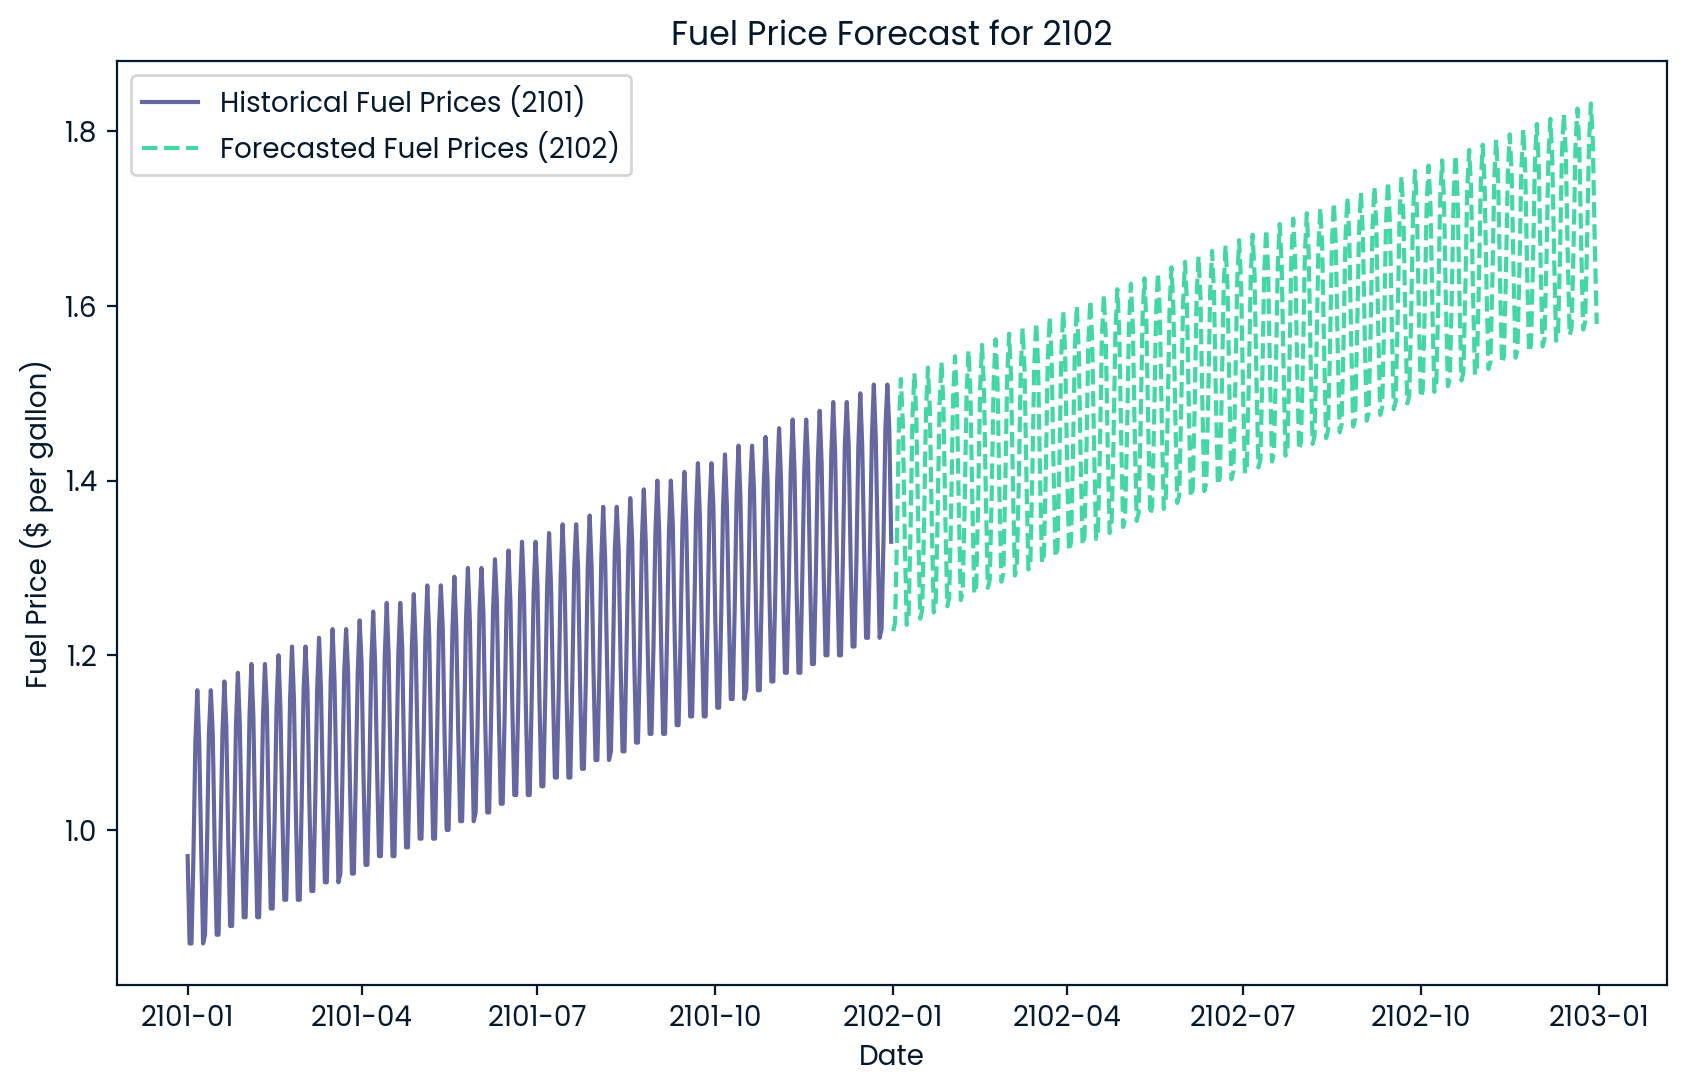

In [35]:
# Plot forecasted fuel prices
plt.figure(figsize=(10, 6))
plt.plot(fuel_prices.index.to_timestamp(), fuel_prices, label='Historical Fuel Prices (2101)')
plt.plot(forecasted_prices['date'], forecasted_prices['fuel_price'], label='Forecasted Fuel Prices (2102)', linestyle='--')
plt.title('Fuel Price Forecast for 2102')
plt.xlabel('Date')
plt.ylabel('Fuel Price ($ per gallon)')
plt.legend()
plt.show()